In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9

In [35]:
# LOAD BOMBUS VISIT DATA WITH INTERVALS AND SPECIES ID, LIMIT TO CLOVER PERIOD
df = pd.read_csv('csvs/bombus_visit_durations.csv', parse_dates=["visit_start", "visit_end"])
bombus_visits_clover = df[df['visit_end'] < pd.Timestamp('2024-07-30')]

In [36]:
bombus_visits_clover.value_counts('species')

species
vosnesenskii    173
fervidus         70
unk              31
griseocollis     13
nevadensis        2
appositus         1
mixtus            1
Name: count, dtype: int64

In [37]:
# PIVOT TO WIDE FORMAT OF COUNTS PER COLOR, COLS ARE COLORS
species_col_visits = pd.DataFrame(bombus_visits_clover[bombus_visits_clover['species'] != 'unk'].groupby(['species', 'color']).size()).reset_index()

species_col_visits.columns = ['species', 'color', 'visit_count']
species_col_wide = species_col_visits.pivot_table(
    index='species',
    columns='color',
    values='visit_count',
    fill_value=0
)

order = ['appositus', 'mixtus', 'nevadensis', 'griseocollis', 'fervidus', 'vosnesenskii']
# color_order = ['cnt', 'blv', 'grn', 'blu', 'yel']
color_order = ['yel','blu', 'grn','blv','cnt']
species_col_wide = species_col_wide[color_order]
species_col_wide = species_col_wide.reindex(order)

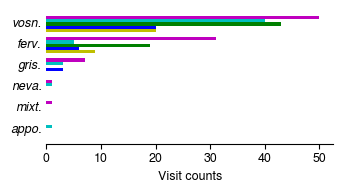

In [38]:
# PLOT SPECIES COUNTS PER STIMULUS TYPE
colors = species_col_wide.columns
species = ['appo', 'mixt', 'neva', 'gris', 'ferv', 'vosn']

color_map = {
    'blu': 'b',
    'blv': 'c',
    'cnt': 'm',
    'grn': 'g',
    'yel': 'y'
}

x = np.arange(len(species))
width = 0.15 

fig, ax = plt.subplots(figsize=(3.5, 2))
for i, color in enumerate(colors):
    ax.barh(x + i * width, species_col_wide[color], width, color=color_map[color])

ax.set_xlabel('Visit counts')
# ax.set_ylabel(r'$\it{Bombus}$ species')

ax.set_yticks(x + width * len(colors) / 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([f"{label}." for label in species], style='italic')

plt.tight_layout()
plt.savefig('figs/stimulus_species_counts_smaller.svg', format='svg')

In [39]:
# LOAD SPECIES COUNTS FOR CAMERA TRAPS, BLUE VANE TRAPS, AND HAND NETTING
cam_bombus_counts = bombus_visits_clover['species'].value_counts()

survey_data = pd.read_csv('csvs/Clover_Bee_occurrence_data.csv')
bvt_data  = survey_data[survey_data['Collection method'] == 'vane trap'].reset_index(drop=True)
net_data  = survey_data[survey_data['Collection method'] == 'net'].reset_index(drop=True)

bvt_taxa = bvt_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
bvt_bombus_counts = bvt_taxa[bvt_taxa['Genus'] == 'Bombus']['Species'].value_counts()

net_taxa = net_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
net_bombus_counts = net_taxa[net_taxa['Genus'] == 'Bombus']['Species'].value_counts()

species_all = list(set(cam_bombus_counts.index).union(bvt_bombus_counts.index, net_bombus_counts.index))

species_all = [
 'caliginosus',
 'mixtus',
 'appositus',
 'nevadensis',
 'griseocollis',
 'fervidus',
 'vosnesenskii']

counts_s1 = [cam_bombus_counts[species] if species in cam_bombus_counts.index else 0 for species in species_all]
counts_s2 = [bvt_bombus_counts[species] if species in bvt_bombus_counts.index else 0 for species in species_all]
counts_s3 = [net_bombus_counts[species] if species in net_bombus_counts.index else 0 for species in species_all]
counts_s1_cnt = [species_col_wide['cnt'][species] if species in cam_bombus_counts.index else 0 for species in species_all]

# NORMALIZE COUNTS TO EFFORT
counts_s1n = [round(x/180, 2) for x in counts_s1] # PER TRAP DAY
counts_s2n = [round(x/16, 2) for x in counts_s2] # PER TRAP DAY
counts_s3n = [round(x/50, 2) for x in counts_s3] # PER SAMPLING MINUTE

df_counts = pd.DataFrame({
    'Species': species_all,
    'Camera': counts_s1,
    'BVT': counts_s2,
    'Net': counts_s3
})

# df_counts.to_csv('method_comparison_fig/sample_method_counts.csv', index=False)

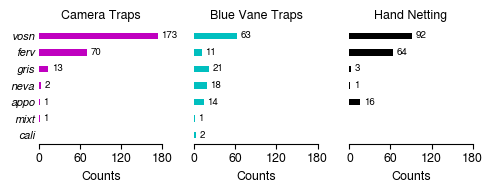

In [40]:
# PLOT METHODS COMPARISON
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  

fig, axs = plt.subplots(1, 3, figsize=(5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Counts', size=9)
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1)), height=bar_width, color='m')
for bar, count in zip(bars0, list(reversed(counts_s1))):
    if count != 0:
        axs[0].text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2)), height=bar_width, color='c')
for bar, count in zip(bars1, list(reversed(counts_s2))):
    if count != 0:
        axs[1].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Counts', size=9)
axs[1].set_title('Blue Vane Traps', size=9)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3))):
    if count != 0:
        axs[2].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Counts', size=9)
axs[2].set_title('Hand Netting', size=9)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, 180)
    ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label[:4] for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
plt.savefig('figs/methods_comparison_separated.svg', format='svg')

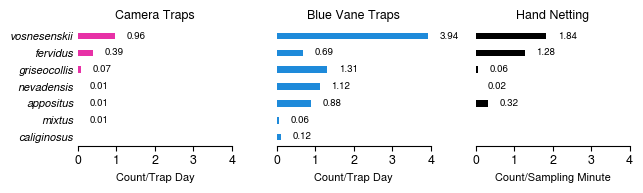

In [ ]:
# PLOT METHODS COMPARISON WITH NORMALIZED COUNTS
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  
text_offset = .3

fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Count/Trap Day', size=8)
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1n)), height=bar_width, color='#e731a6ff')
for bar, count in zip(bars0, list(reversed(counts_s1n))):
    if count != 0:
        axs[0].text(
            bar.get_width() + text_offset,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2n)), height=bar_width, color='#1e8adaff')
for bar, count in zip(bars1, list(reversed(counts_s2n))):
    if count != 0:
        axs[1].text(bar.get_width() + text_offset, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Count/Trap Day', size=8)
axs[1].set_title('Blue Vane Traps', size=9)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3n)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3n))):
    if count != 0:
        axs[2].text(bar.get_width() + text_offset, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Count/Sampling Minute', size=8)
axs[2].set_title('Hand Netting', size=9)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, 4)
    # ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
# plt.savefig('figs/methods_comparison_separated_norm.svg', format='svg')

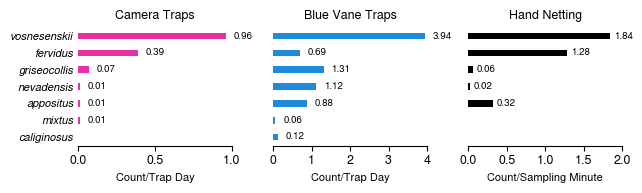

In [91]:
# PLOT METHODS COMPARISON WITH NORMALIZED COUNTS
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  
text_offset = .3

fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Count/Trap Day', size=8)
axs[0].set_xlim(0,1)
axs[0].set_xticks([0,0.5,1])
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1n)), height=bar_width, color='#e731a6ff')
for bar, count in zip(bars0, list(reversed(counts_s1n))):
    if count != 0:
        axs[0].text(
            bar.get_width() + .05,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2n)), height=bar_width, color='#1e8adaff')
for bar, count in zip(bars1, list(reversed(counts_s2n))):
    if count != 0:
        axs[1].text(bar.get_width() + .2, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Count/Trap Day', size=8)
axs[1].set_title('Blue Vane Traps', size=9)
axs[1].set_xlim(0,4)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3n)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3n))):
    if count != 0:
        axs[2].text(bar.get_width() + .05, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
        
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Count/Sampling Minute', size=8)
axs[2].set_title('Hand Netting', size=9)
axs[2].set_xlim(0,2)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    # ax.set_xlim(0, 4)
    # ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
plt.savefig('figs/methods_comparison_separated_norm_edit.svg', format='svg')

In [42]:
# # PREP AND EXPORT ABUNDANCE COUNTS FOR iNEXT
# cam_bombus_counts = cam_bombus_counts.to_frame()
# cam_abund = cam_bombus_counts.sum(axis=1).to_dict()
# cam_abund.pop('unk')
# bvt_bombus_counts = bvt_bombus_counts.to_frame()
# bvt_abund = bvt_bombus_counts.sum(axis=1).to_dict()
# net_bombus_counts = net_bombus_counts.to_frame()
# net_abund = net_bombus_counts.sum(axis=1).to_dict()

# abundance_list = {
#     "camera": cam_abund,
#     "bvt": bvt_abund,
#     "net": net_abund
# }

# abundance_list_norm = {
#     "camera": [int(x*100) for x in counts_s1n],
#     "bvt": [int(x*100) for x in counts_s2n],
#     "net": [int(x*100) for x in counts_s3n]
# }

# import json

# all_species = set()
# for method_data in abundance_list.values():
#     all_species.update(method_data.keys())
# all_species = sorted(all_species)

# inext_ready = {
#     method: [method_data.get(species, 0) for species in all_species]
#     for method, method_data in abundance_list.items()
# }

# with open("csvs/abundance_list.json", "w") as f:
#     json.dump(inext_ready, f)

# with open("csvs/abundance_list_norm.json", "w") as f:
#     json.dump(abundance_list_norm, f)



In [43]:
# EXPORT TO R
inext_ready = [counts_s1_cnt, counts_s2, counts_s3]

%load_ext rpy2.ipython
%R -i inext_ready

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
%%R
library(iNEXT)

out_df <- iNEXT(inext_ready, q = c(0,1,2), datatype = "abundance", nboot=1000)
asy_est <- out_df$AsyEst
datainfo <- out_df$DataInfo
size_est <- out_df$iNextEst$size_based
coverage_est <- out_df$iNextEst$coverage_based

In [45]:
%R -o datainfo
%R -o asy_est
%R -o size_est
%R -o coverage_est

In [46]:
div_dict = {"Species richness":0, "Shannon diversity":1, "Simpson diversity":2}
assem_dict = {"assemblage1":"cam", "assemblage2":"bvt", "assemblage3":"net"}
asy_est['Diversity'] = asy_est['Diversity'].replace(div_dict)

for dataframe in [asy_est, datainfo, size_est, coverage_est]:
    dataframe['Assemblage'] = dataframe['Assemblage'].replace(assem_dict)

In [47]:
coverage_est.columns

Index(['Assemblage', 'SC', 'm', 'Method', 'Order.q', 'qD', 'qD.LCL', 'qD.UCL'], dtype='object')

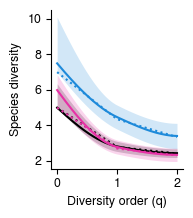

In [ ]:
import numpy as np
from scipy.interpolate import PchipInterpolator

method_color_map = {'cam':'#e731a6ff', 'bvt':'#1e8adaff', 'net':'k'}
order = ["net", "cam", "bvt"] 

fig, ax = plt.subplots(figsize=(2,2.25))

for assemblage in order:
    subdf = asy_est[asy_est["Assemblage"] == assemblage]
    x = subdf["Diversity"].values.astype(float)
    y = subdf["Estimator"].values.astype(float)
    lcl = subdf["LCL"].values.astype(float)
    ucl = subdf["UCL"].values.astype(float)
    obs = subdf["Observed"].values.astype(float)

    color = method_color_map.get(assemblage, "k")
    x_smooth = np.linspace(x.min(), x.max(), 200)
    f_est = PchipInterpolator(x, y)
    f_lcl = PchipInterpolator(x, lcl)
    f_ucl = PchipInterpolator(x, ucl)

    y_smooth = f_est(x_smooth)
    lcl_smooth = f_lcl(x_smooth)
    ucl_smooth = f_ucl(x_smooth)

    ax.plot(x_smooth, y_smooth, color=color, linestyle="-", label=f"{assemblage} (Estimator)")
    ax.fill_between(x_smooth, lcl_smooth, ucl_smooth, color=color, alpha=0.2, linewidth=0)
    ax.plot(x, obs, color=color, linestyle=":", alpha=1, label=f"{assemblage} (Observed)")

# ax.set_title("Asymptotic Diversity Estimates (Smoothed with PCHIP)")
ax.set_xlabel("Diversity order (q)")
ax.set_ylabel("Species diversity")
# ax.set_title("Asymptotic Diversity Estimates")
ax.set_xticks([0,1,2], labels=[0,1,2])


plt.tight_layout()
plt.savefig('figs/asyest_methods.svg', format='svg')


In [49]:
size_est

,Assemblage,m,Method,Order.q,qD,qD.LCL,qD.UCL,SC,SC.LCL,SC.UCL
1,cam,1.0,Rarefaction,0.0,1.000000,1.000000,1.000000,0.427216,0.361964,0.492468
2,cam,5.0,Rarefaction,0.0,2.321592,2.102231,2.540952,0.873021,0.832837,0.913205
3,cam,10.0,Rarefaction,0.0,2.785906,2.437118,3.134694,0.936226,0.913811,0.958640
4,cam,15.0,Rarefaction,0.0,3.066803,2.648088,3.485518,0.952622,0.934640,0.970605
5,cam,20.0,Rarefaction,0.0,3.283941,2.818389,3.749492,0.961709,0.945197,0.978220
...,...,...,...,...,...,...,...,...,...,...
356,net,315.0,Extrapolation,2.0,2.423743,2.174456,2.673029,1.000000,0.998830,1.000000
357,net,324.0,Extrapolation,2.0,2.424048,2.174677,2.673419,1.000000,0.998943,1.000000
358,net,333.0,Extrapolation,2.0,2.424337,2.174886,2.673788,1.000000,0.999046,1.000000
359,net,342.0,Extrapolation,2.0,2.424611,2.175083,2.674138,1.000000,0.999139,1.000000


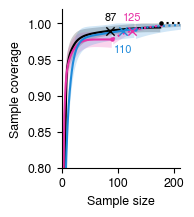

In [71]:
from scipy.optimize import brentq  # root-finding for inverse lookup

fig, ax = plt.subplots(figsize=(2,2.25))

order_q = 0
df_filtered = size_est[size_est['Order.q'] == order_q]

coverage_targets = [0.99]

for assemblage in order:
    subdf = df_filtered[df_filtered["Assemblage"] == assemblage]
    color = method_color_map.get(assemblage, "gray")

    rare = subdf[subdf["Method"] == "Rarefaction"].sort_values("m")
    if not rare.empty:
        f_y = PchipInterpolator(rare["m"], rare["SC"])
        f_lcl = PchipInterpolator(rare["m"], rare["SC.LCL"])
        f_ucl = PchipInterpolator(rare["m"], rare["SC.UCL"])
        x_smooth = np.linspace(rare["m"].min(), rare["m"].max(), 200)

        ax.plot(x_smooth, f_y(x_smooth), color=color, label=assemblage)
        ax.fill_between(x_smooth, f_lcl(x_smooth), f_ucl(x_smooth),
                        color=color, alpha=0.2, linewidth=0)

        for target in coverage_targets:
            try:
                m_target = brentq(lambda xx: f_y(xx) - target,
                                  rare["m"].min(), rare["m"].max())
                ax.scatter(m_target, target, color=color, marker="x", zorder=4, linewidths=1)
                if assemblage == 'bvt':
                    ax.text(m_target, target - .03,
                            f"{int(round(m_target))}",
                            color=color, fontsize=8, ha="center")
                else:
                    ax.text(m_target, target + 0.015,
                            f"{int(round(m_target))}",
                            color=color, fontsize=8, ha="center")
            except ValueError:
                pass

    obs = subdf[subdf["Method"] == "Observed"]
    if not obs.empty:
        ax.scatter(obs["m"], obs["SC"], color=color, marker="o", s=5,
                   edgecolor=None, zorder=3)

    extra = subdf[subdf["Method"] == "Extrapolation"].sort_values("m")
    if not extra.empty:
        f_y = PchipInterpolator(extra["m"], extra["SC"])
        f_lcl = PchipInterpolator(extra["m"], extra["SC.LCL"])
        f_ucl = PchipInterpolator(extra["m"], extra["SC.UCL"])
        x_smooth = np.linspace(extra["m"].min(), extra["m"].max(), 200)

        ax.plot(x_smooth, f_y(x_smooth), color=color, linestyle="dotted")
        ax.fill_between(x_smooth, f_lcl(x_smooth), f_ucl(x_smooth),
                        color=color, alpha=0.2, linewidth=0)

        for target in coverage_targets:
            try:
                m_target = brentq(lambda xx: f_y(xx) - target,
                                  extra["m"].min(), extra["m"].max())
                ax.scatter(m_target, target, color=color, marker="x", zorder=4, linewidths=1)
                ax.text(m_target, target+0.015,
                        f"{int(round(m_target))}",
                        color=color, fontsize=8, ha="center")
            except ValueError:
                pass


ax.set_ylim(0.80, 1.02)
ax.set_xlim(0,210)
ax.set_xlabel("Sample size")
ax.set_xticks([0,100,200])
ax.set_ylabel("Sample coverage")
plt.tight_layout()
plt.savefig('figs/coverage_est.svg', format='svg')

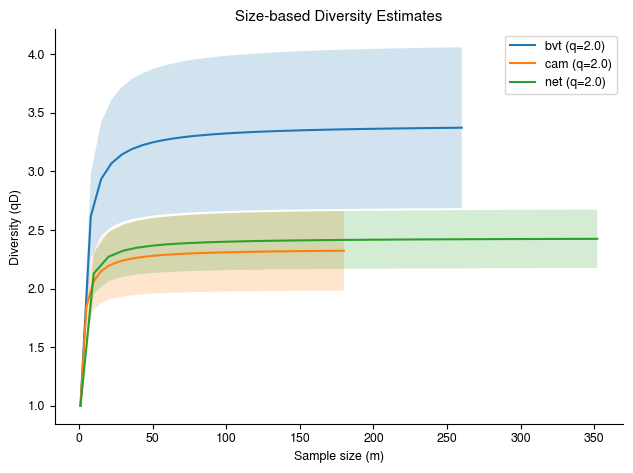

In [51]:
fig, ax = plt.subplots()

q = 2

df_q = size_est[size_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    ax.plot(
        subdf["m"], subdf["qD"], label=f"{assemblage} (q={q})"
    )
    ax.fill_between(
        subdf["m"], subdf["qD.LCL"], subdf["qD.UCL"], alpha=0.2
    )

ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Diversity (qD)")
ax.set_title("Size-based Diversity Estimates")
ax.legend()
plt.tight_layout()

In [52]:
coverage_est

,Assemblage,SC,m,Method,Order.q,qD,qD.LCL,qD.UCL
1,cam,0.427219,1.0,Rarefaction,0.0,1.000007,0.910123,1.089891
2,cam,0.873021,5.0,Rarefaction,0.0,2.321592,1.945530,2.697653
3,cam,0.936226,10.0,Rarefaction,0.0,2.785907,2.262535,3.309279
4,cam,0.952622,15.0,Rarefaction,0.0,3.066804,2.472643,3.660965
5,cam,0.961709,20.0,Rarefaction,0.0,3.283941,2.654656,3.913226
...,...,...,...,...,...,...,...,...
296,net,0.993864,146.0,Rarefaction,2.0,2.411088,2.164598,2.657578
297,net,0.994105,155.0,Rarefaction,2.0,2.412451,2.166055,2.658848
298,net,0.994268,165.0,Rarefaction,2.0,2.413793,2.167547,2.660039
299,net,0.994318,174.0,Rarefaction,2.0,2.414923,2.169296,2.660550


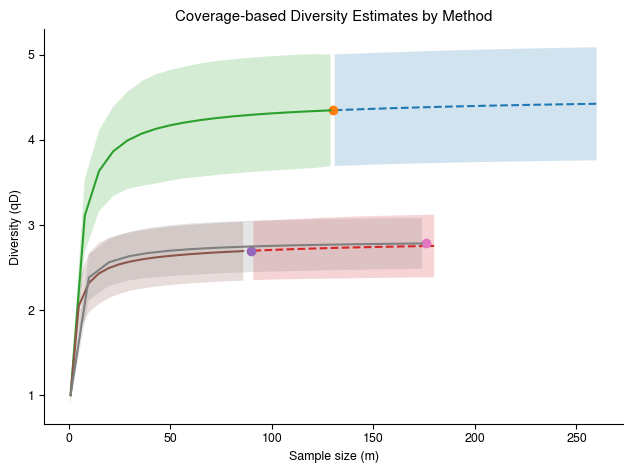

In [53]:
fig, ax = plt.subplots()

method_styles = {
    "Rarefaction": {"linestyle": "-", "marker": ""},
    "Observed": {"linestyle": "None", "marker": "o"},
    "Extrapolation": {"linestyle": "--", "marker": ""}
}

q = 1

df_q = coverage_est[coverage_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    for method, mdf in subdf.groupby("Method"):
        style = method_styles.get(method, {"linestyle": "-", "marker": ""})
        ax.plot(
            mdf["m"], mdf["qD"],
            label=f"{assemblage}, q={q}, {method}",
            **style
        )
        ax.fill_between(
            mdf["m"], mdf["qD.LCL"], mdf["qD.UCL"],
            alpha=0.2
        )

ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Diversity (qD)")
ax.set_title("Coverage-based Diversity Estimates by Method")
# ax.legend()
plt.tight_layout()

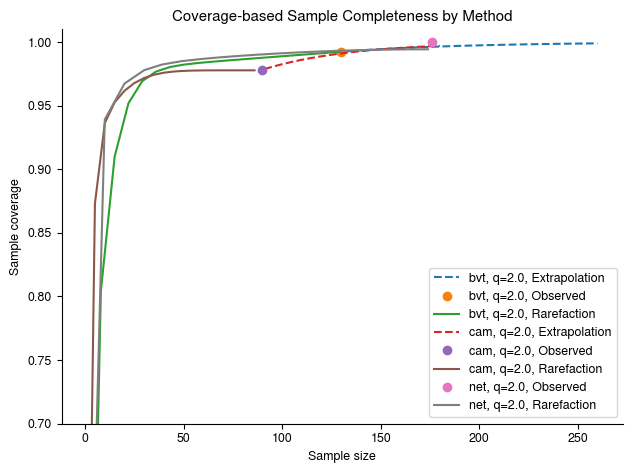

In [54]:
fig, ax = plt.subplots()

method_styles = {
    "Rarefaction": {"linestyle": "-", "marker": ""},
    "Observed": {"linestyle": "None", "marker": "o"},
    "Extrapolation": {"linestyle": "--", "marker": ""}
}

q = 2
df_q = coverage_est[coverage_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    for method, mdf in subdf.groupby("Method"):
        style = method_styles.get(method, {"linestyle": "-", "marker": ""})
        ax.plot(
            mdf["m"], mdf["SC"],
            label=f"{assemblage}, q={q}, {method}",
            **style
        )
        if "SC.LCL" in mdf and "SC.UCL" in mdf:
            ax.fill_between(
                mdf["m"], mdf["SC.LCL"], mdf["SC.UCL"],
                alpha=0.2
            )

ax.set_xlabel("Sample size")
ax.set_ylabel("Sample coverage")
ax.set_title("Coverage-based Sample Completeness by Method")
ax.set_ylim(0.7, 1.01)
# ax.set_xlim(0, 300)
ax.legend()
plt.tight_layout()